In [ ]:
# Cell 1: install libraries (run once in notebook environment)

# standard imports
import os
import random
import math
import copy
import time
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import torch
from torch import nn

from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed


In [ ]:
# Cell 2: configuration & reproducibility (replace original Cell 2)
from transformers import set_seed

set_seed(42)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# Few-shot settings
K_SHOT = 4             # <<--- Use a small fixed few-shot set (4, 8, or 10 are common choices)
MAX_TEST_EXAMPLES = None  # set to an int to limit eval size (None => use all)
MAX_NEW_TOKENS = 8     # how many tokens the model will generate when asked for sentiment
NOISE_EPS = 1e-2       # scale of the Gaussian noise to inject into head columns (tunable)
BATCH_INFERENCE = False  # keep simple and do one-by-one generation
VERBOSE = True


In [ ]:
# Cell 3: load the provided CSV file
CSV_PATH = "IMDB_Dataset_100.csv"
df = pd.read_csv(CSV_PATH)
print("Loaded dataset shape:", df.shape)
df.head(3)


In [ ]:
# Cell 4: simple preprocessing + fixed few-shot selection (replace original Cell 4)

# Basic cleanup: remove HTML tags like <br /> to reduce token bloat
def clean_review_text(s: str) -> str:
    if not isinstance(s, str):
        s = str(s)
    s = s.replace("<br />", " ").replace("<br/>", " ").replace("<br>", " ")
    s = " ".join(s.split())
    return s

df["review"] = df["review"].apply(clean_review_text)

# shuffle reproducibly, then take first K_SHOT as the fixed few-shot examples
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# fixed few-shot examples (first K_SHOT rows)
assert K_SHOT >= 1 and K_SHOT < len(df), "K_SHOT must be at least 1 and less than dataset size"
few_shot_examples = df.iloc[:K_SHOT].reset_index(drop=True)

# rest of dataset is evaluation set
eval_set = df.iloc[K_SHOT:].reset_index(drop=True)

print(f"Using fixed K_SHOT = {K_SHOT} few-shot examples.")
print(f"Few-shot examples: {len(few_shot_examples)}")
print(f"Evaluation examples: {len(eval_set)}")
few_shot_examples.head()


In [ ]:

from transformers import AutoModelForCausalLM, AutoTokenizer
MODEL_NAME = "EleutherAI/gpt-neo-125M"   # 
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME).to(DEVICE)
model.eval()
# get some model attributes we need
config = model.config
n_layers= config.num_layers
n_heads = config.num_heads
embed_dim = config.hidden_size
head_dim = embed_dim // n_heads

print(f"Model: {MODEL_NAME} | layers: {n_layers}, heads: {n_heads}, embed_dim: {embed_dim}, head_dim: {head_dim}")
print("tokenizer.model_max_length =", tokenizer.model_max_length)


In [ ]:
# Cell 6: safe prompt building & generation helpers (replace original Cell 6)
# These helpers ensure the prompt fits within the model's token limit by truncating at token level.

def build_prompt_from_pairs(few_shot_examples_list, test_review):
    """
    few_shot_examples_list: list of tuples (review_text, sentiment_label)
    """
    parts = []
    for r, s in few_shot_examples_list:
        parts.append(f"Review: {r}\nSentiment: {s}\n")
    parts.append(f"Review: {test_review}\nSentiment:")
    return "\n".join(parts)

def safe_build_prompt_and_encode(test_review, few_shot_examples_list, tokenizer, max_new_tokens=MAX_NEW_TOKENS, verbose=False):
    """
    Ensure the prompt + generated tokens will fit within tokenizer.model_max_length.
    Returns: prompt_text, input_ids tensor (on DEVICE)
    """
    model_limit = tokenizer.model_max_length
    max_input_tokens = max(16, model_limit - max_new_tokens - 4)

    # encode each few-shot pair at token-level
    encoded_fs = []
    for (r, s) in few_shot_examples_list:
        rt = tokenizer.encode(r, add_special_tokens=False)
        lt = tokenizer.encode(s, add_special_tokens=False)
        encoded_fs.append((rt, lt))

    test_tokens = tokenizer.encode(test_review, add_special_tokens=False)

    overhead_tokens_per_example = 6
    total_tokens = sum(len(rt) + len(lt) + overhead_tokens_per_example for rt, lt in encoded_fs) + len(test_tokens) + overhead_tokens_per_example

    if total_tokens <= max_input_tokens:
        prompt_text = build_prompt_from_pairs(few_shot_examples_list, test_review)
        input_ids = tokenizer(prompt_text, return_tensors="pt").input_ids.to(DEVICE)
        return prompt_text, input_ids

    # Truncate each item to a fair per-item budget (keep the beginning of each review)
    num_items = max(1, len(encoded_fs) + 1)
    per_item_budget = max(16, max_input_tokens // num_items)

    truncated_fs = []
    for (rt, lt), (r, s) in zip(encoded_fs, few_shot_examples_list):
        rt_trunc = rt[:per_item_budget]
        truncated_review = tokenizer.decode(rt_trunc, clean_up_tokenization_spaces=True)
        truncated_fs.append((truncated_review, s))
    test_trunc = test_tokens[:per_item_budget]
    test_trunc_text = tokenizer.decode(test_trunc, clean_up_tokenization_spaces=True)

    prompt_text = build_prompt_from_pairs(truncated_fs, test_trunc_text)
    input_ids = tokenizer(prompt_text, return_tensors="pt").input_ids.to(DEVICE)
    if input_ids.shape[-1] <= max_input_tokens:
        if verbose:
            print(f"Built truncated prompt with length {input_ids.shape[-1]} tokens (budget {max_input_tokens})")
        return prompt_text, input_ids

    # Reduce few-shot count progressively (drop last example until fits)
    fs_copy = few_shot_examples_list.copy()
    while len(fs_copy) > 0:
        fs_copy = fs_copy[:-1]
        prompt_text = build_prompt_from_pairs(fs_copy, test_trunc_text)
        input_ids = tokenizer(prompt_text, return_tensors="pt").input_ids.to(DEVICE)
        if input_ids.shape[-1] <= max_input_tokens:
            if verbose:
                print(f"Reduced K_shot to {len(fs_copy)} to fit prompt (len {input_ids.shape[-1]} tokens)")
            return prompt_text, input_ids

    # Last resort: zero-shot truncated prompt
    test_trunc = test_tokens[:max_input_tokens]
    test_trunc_text = tokenizer.decode(test_trunc, clean_up_tokenization_spaces=True)
    prompt_text = f"Review: {test_trunc_text}\nSentiment:"
    input_ids = tokenizer(prompt_text, return_tensors="pt").input_ids.to(DEVICE)
    if verbose:
        print(f"Fell back to zero-shot/truncated prompt length {input_ids.shape[-1]} (budget {max_input_tokens})")
    return prompt_text, input_ids

def predict_sentiment_for_input_ids(input_ids, model, tokenizer, max_new_tokens=MAX_NEW_TOKENS):
    """
    Generate continuation (greedy) and map to 'positive'/'negative'
    """
    input_ids = input_ids.to(DEVICE)
    with torch.no_grad():
        outputs = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            eos_token_id=None,
        )
    gen_tokens = outputs[0, input_ids.shape[-1]:]
    generated = tokenizer.decode(gen_tokens, skip_special_tokens=True).strip().lower()
    if "positive" in generated:
        pred = "positive"
    elif "negative" in generated:
        pred = "negative"
    else:
        if generated.startswith("pos") or "good" in generated or "great" in generated:
            pred = "positive"
        elif generated.startswith("neg") or "bad" in generated or "terrible" in generated:
            pred = "negative"
        else:
            pred = "positive"  # fallback to default
    return pred, generated


In [ ]:
# Cell 7: baseline evaluation using the fixed few-shot examples (replace original Cell 7)

def evaluate_model_on_evalset_fixed_fs(model, tokenizer, few_shot_examples_df, eval_set_df, max_examples=None, verbose=False):
    """
    Evaluate model using the same few-shot examples for every test input.
    few_shot_examples_df: DataFrame with columns 'review' and 'sentiment' (length K_SHOT)
    """
    correct = 0
    total = 0
    details = []

    # prepare few-shot list of tuples once
    fs_pairs = list(zip(few_shot_examples_df["review"].tolist(), few_shot_examples_df["sentiment"].tolist()))

    idxs = list(range(len(eval_set_df))) if max_examples is None else list(range(min(max_examples, len(eval_set_df))))

    for i in tqdm(idxs, desc="Evaluating", leave=False):
        test_row = eval_set_df.iloc[i]
        test_review = test_row["review"]
        true_label = test_row["sentiment"]

        # build prompt safely and get input_ids
        prompt_text, input_ids = safe_build_prompt_and_encode(test_review, fs_pairs, tokenizer, max_new_tokens=MAX_NEW_TOKENS, verbose=False)

        # generate and map to label
        try:
            pred, gen_text = predict_sentiment_for_input_ids(input_ids, model, tokenizer, max_new_tokens=MAX_NEW_TOKENS)
        except IndexError as e:
            # fallback to zero-shot/truncated prompt
            if verbose:
                print(f"IndexError on example {i}: {e}. Falling back to truncated zero-shot prompt.")
            prompt_text, input_ids = safe_build_prompt_and_encode(test_review, [], tokenizer, max_new_tokens=MAX_NEW_TOKENS, verbose=True)
            pred, gen_text = predict_sentiment_for_input_ids(input_ids, model, tokenizer, max_new_tokens=MAX_NEW_TOKENS)

        is_correct = (pred == true_label)
        correct += int(is_correct)
        total += 1
        details.append({"index": i, "true": true_label, "pred": pred, "gen": gen_text, "prompt_len": input_ids.shape[-1]})

    acc = correct / total if total > 0 else 0.0
    return acc, details

# run baseline
print("Running baseline evaluation with fixed few-shot examples...")
baseline_acc, baseline_details = evaluate_model_on_evalset_fixed_fs(model, tokenizer, few_shot_examples, eval_set, max_examples=MAX_TEST_EXAMPLES)
print(f"Baseline accuracy: {baseline_acc:.4f} ({int(baseline_acc*100)}%) over {len(baseline_details)} examples")


In [ ]:
# Cell A: inspect Linear modules in the last transformer block to identify the attention "output" projection.
import torch.nn as nn

last_block = model.transformer.h[-1]
print("Last block type:", type(last_block))
print("\nListing all nn.Linear modules (name -> weight.shape) in last_block (and submodules):\n")
linear_candidates = []
for nm, mod in last_block.named_modules():
    if isinstance(mod, nn.Linear):
        shape = tuple(mod.weight.shape)
        linear_candidates.append((nm, shape))
        print(f"{nm:40s} -> {shape}")



In [ ]:
# Cell 1: explicitly pick the out_proj discovered in Cell A and set c_proj
import torch.nn as nn

# last_block should already be defined
# From your inspection: the out proj name printed was "attn.attention.out_proj"
TARGET_CPROJ_NAME = "attn.attention.out_proj"

c_proj = None
c_proj_name = None
for nm, mod in last_block.named_modules():
    if nm == TARGET_CPROJ_NAME and isinstance(mod, nn.Linear):
        c_proj = mod
        c_proj_name = nm
        break

if c_proj is None:
    # fallback: auto-detect the "out" linear with correct shape
    for nm, mod in last_block.named_modules():
        if isinstance(mod, nn.Linear) and ('out' in nm.lower() or 'o_proj' in nm.lower() or 'out_proj' in nm.lower() or 'c_proj' in nm.lower()):
            if tuple(mod.weight.shape) == (embed_dim, embed_dim):
                c_proj = mod
                c_proj_name = nm
                break

if c_proj is None:
    # last-resort search by shape only
    for nm, mod in last_block.named_modules():
        if isinstance(mod, nn.Linear) and tuple(mod.weight.shape) == (embed_dim, embed_dim):
            c_proj = mod
            c_proj_name = nm
            break

if c_proj is None:
    raise RuntimeError("Couldn't find c_proj. Re-run the inspection cell and ensure TARGET_CPROJ_NAME matches a printed name from Cell A.")

print(f"Using c_proj = '{c_proj_name}' with shape {tuple(c_proj.weight.shape)}")
# compute head_dim again to be safe
n_heads = n_heads  # should exist
head_dim = embed_dim // n_heads
print(f"embed_dim={embed_dim}, n_heads={n_heads}, head_dim={head_dim}")


In [ ]:
# Cell 2: quick sanity test on a single head (head 0) with noise=0.2 and zero-out
import torch
from copy import deepcopy

TEST_HEAD = 0
NOISE_EPS_TEST = 0.05

def perturb_once_and_eval(c_proj_layer, head_idx, noise_eps):
    # add noise and return restore fn
    W = c_proj_layer.weight.data
    b = c_proj_layer.bias.data if c_proj_layer.bias is not None else None
    start = head_idx * head_dim
    end = (head_idx + 1) * head_dim
    W_backup = W.clone()
    b_backup = b.clone() if b is not None else None
    noise = noise_eps * torch.randn_like(W[:, start:end], device=W.device)
    W[:, start:end] += noise
    def restore():
        c_proj_layer.weight.data.copy_(W_backup)
        if b is not None:
            c_proj_layer.bias.data.copy_(b_backup)
    return restore

def zero_once_and_eval(c_proj_layer, head_idx):
    W = c_proj_layer.weight.data
    b = c_proj_layer.bias.data if c_proj_layer.bias is not None else None
    start = head_idx * head_dim
    end = (head_idx + 1) * head_dim
    W_backup = W.clone()
    b_backup = b.clone() if b is not None else None
    W[:, start:end] = 0.0
    def restore():
        c_proj_layer.weight.data.copy_(W_backup)
        if b is not None:
            c_proj_layer.bias.data.copy_(b_backup)
    return restore

# Baseline must already be computed
print(f"Baseline accuracy (assumed precomputed): {baseline_acc:.4f}")

# Noise test
restore = perturb_once_and_eval(c_proj, TEST_HEAD, NOISE_EPS_TEST)
noisy_acc, _ = evaluate_model_on_evalset_fixed_fs(model, tokenizer, few_shot_examples, eval_set, max_examples=MAX_TEST_EXAMPLES)
restore()
print(f"Noisy perturbation (eps={NOISE_EPS_TEST}) head {TEST_HEAD} -> acc={noisy_acc:.4f} (delta={baseline_acc - noisy_acc:+.4f})")

# Zeroing test
restore = zero_once_and_eval(c_proj, TEST_HEAD)
zero_acc, _ = evaluate_model_on_evalset_fixed_fs(model, tokenizer, few_shot_examples, eval_set, max_examples=MAX_TEST_EXAMPLES)
restore()
print(f"Zeroing head {TEST_HEAD} -> acc={zero_acc:.4f} (delta={baseline_acc - zero_acc:+.4f})")


In [ ]:
# Cell 3: full repeated experiment (noise repeats + zeroing ablation) using the selected c_proj.
import numpy as np
from tqdm.auto import tqdm
import pandas as pd

# Experiment config (tune these)
NOISE_EPS = 0.05   # smaller and less noisy than 0.2; change if you want to test 0.2
REPEATS = 5        # number of random noise draws per head
ZEROING = True
VERBOSE = True

def perturb_head_and_eval(c_proj_layer, head_idx, noise_eps):
    W = c_proj_layer.weight.data
    b = c_proj_layer.bias.data if c_proj_layer.bias is not None else None
    start = head_idx * head_dim
    end = (head_idx + 1) * head_dim
    W_backup = W.clone()
    b_backup = b.clone() if b is not None else None
    noise = noise_eps * torch.randn_like(W[:, start:end], device=W.device)
    W[:, start:end] += noise
    # eval
    acc, _ = evaluate_model_on_evalset_fixed_fs(model, tokenizer, few_shot_examples, eval_set, max_examples=MAX_TEST_EXAMPLES)
    # restore
    c_proj_layer.weight.data.copy_(W_backup)
    if b is not None:
        c_proj_layer.bias.data.copy_(b_backup)
    return acc

def zero_head_and_eval(c_proj_layer, head_idx):
    W = c_proj_layer.weight.data
    b = c_proj_layer.bias.data if c_proj_layer.bias is not None else None
    start = head_idx * head_dim
    end = (head_idx + 1) * head_dim
    W_backup = W.clone()
    b_backup = b.clone() if b is not None else None
    W[:, start:end] = 0.0
    # eval
    acc, _ = evaluate_model_on_evalset_fixed_fs(model, tokenizer, few_shot_examples, eval_set, max_examples=MAX_TEST_EXAMPLES)
    # restore
    c_proj_layer.weight.data.copy_(W_backup)
    if b is not None:
        c_proj_layer.bias.data.copy_(b_backup)
    return acc

head_results = []
print("Running repeated perturbation experiments (this may take time)...")
for head_idx in range(n_heads):
    if VERBOSE:
        print(f"\n=== Head {head_idx} / {n_heads-1} ===")
    # noise repeats
    accs = []
    for r in range(REPEATS):
        acc_r = perturb_head_and_eval(c_proj, head_idx, NOISE_EPS)
        accs.append(acc_r)
        if VERBOSE:
            print(f" noise repeat {r+1}/{REPEATS}: acc={acc_r:.4f}")
    noise_mean = float(np.mean(accs))
    noise_std = float(np.std(accs, ddof=1)) if REPEATS > 1 else 0.0
    noise_contrib = baseline_acc - noise_mean

    # zeroing ablation
    zero_acc = None
    zero_contrib = None
    if ZEROING:
        zero_acc = zero_head_and_eval(c_proj, head_idx)
        zero_contrib = baseline_acc - zero_acc
        if VERBOSE:
            print(f" zeroing: acc={zero_acc:.4f} (delta={zero_contrib:+.4f})")

    head_results.append({
        "head": head_idx,
        "noise_mean_acc": noise_mean,
        "noise_std_acc": noise_std,
        "noise_contrib": noise_contrib,
        "zero_acc": zero_acc,
        "zero_contrib": zero_contrib
    })

# create DataFrame and sort
df_results = pd.DataFrame(head_results)
df_results = df_results.sort_values(by="zero_contrib", ascending=False).reset_index(drop=True)
df_results.index = df_results.index + 1
display(df_results)

OUTNAME = "head_perturbation_outproj_results.csv"
df_results.to_csv(OUTNAME, index=False)
print(f"Saved results to {OUTNAME}")


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your results CSV
CSV_PATH = "head_perturbation_outproj_results.csv"
df = pd.read_csv(CSV_PATH)

# Baseline accuracy must be known
baseline_acc = 0.6421  # already computed earlier in your notebook

df.head()


,head,noise_mean_acc,noise_std_acc,noise_contrib,zero_acc,zero_contrib
0,10,0.629474,0.004708,0.012632,0.600000,0.042105
1,2,0.633684,0.015613,0.008421,0.610526,0.031579
2,3,0.631579,0.000000,0.010526,0.631579,0.010526
3,1,0.631579,0.000000,0.010526,0.631579,0.010526
4,7,0.631579,0.007443,0.010526,0.631579,0.010526


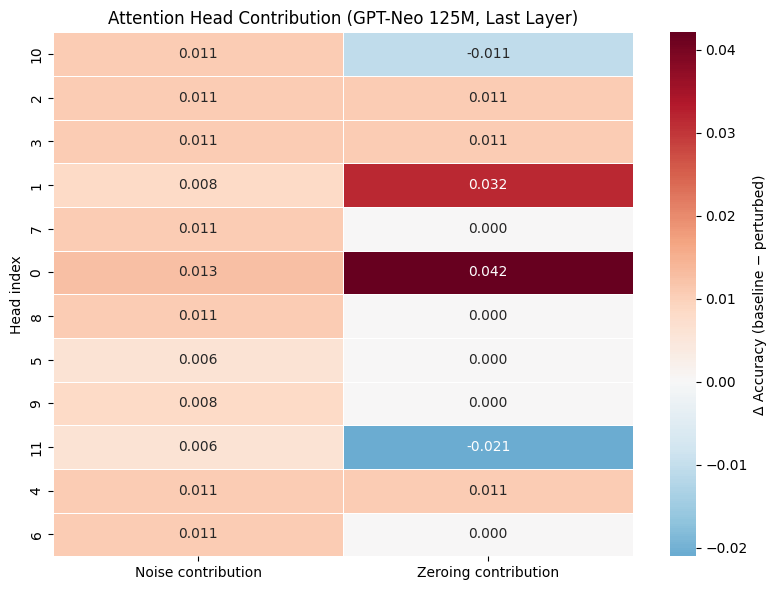

In [9]:
# Prepare data for heatmap
contrib_df = pd.DataFrame({
    "Noise contribution": df["noise_contrib"],
    "Zeroing contribution": df["zero_contrib"]
}, index=df["head"])

plt.figure(figsize=(8, 6))
sns.heatmap(
    contrib_df,
    annot=True,
    fmt=".3f",
    cmap="RdBu_r",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Δ Accuracy (baseline − perturbed)"}
)

plt.title("Attention Head Contribution (GPT-Neo 125M, Last Layer)")
plt.ylabel("Head index")
plt.xlabel("")
plt.tight_layout()
plt.show()


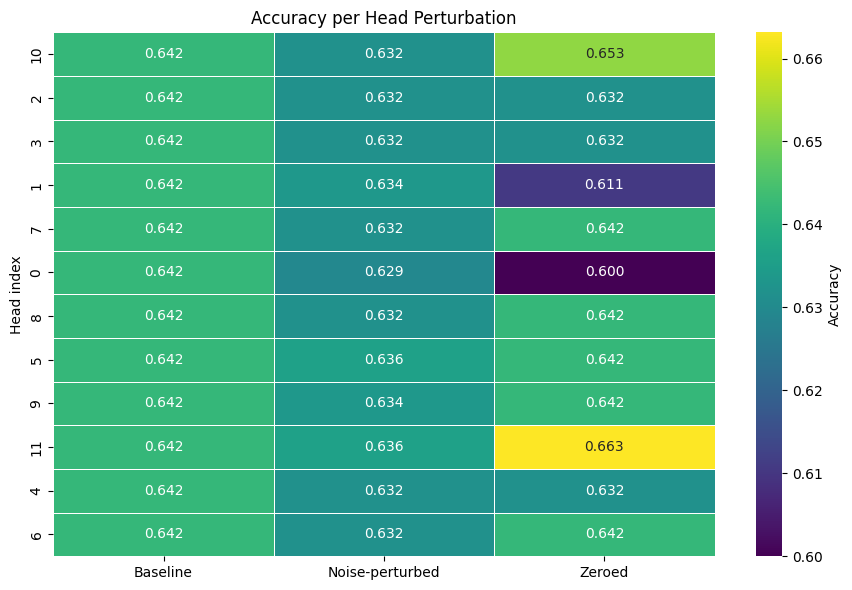

In [10]:
acc_df = pd.DataFrame({
    "Baseline": [baseline_acc] * len(df),
    "Noise-perturbed": df["noise_mean_acc"],
    "Zeroed": df["zero_acc"]
}, index=df["head"])

plt.figure(figsize=(9, 6))
sns.heatmap(
    acc_df,
    annot=True,
    fmt=".3f",
    cmap="viridis",
    linewidths=0.5,
    cbar_kws={"label": "Accuracy"}
)

plt.title("Accuracy per Head Perturbation")
plt.ylabel("Head index")
plt.xlabel("")
plt.tight_layout()
plt.show()


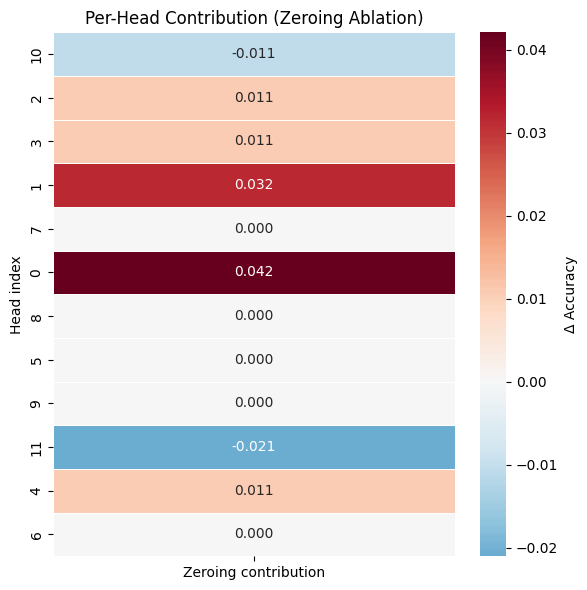

In [11]:
plt.figure(figsize=(6, 6))
sns.heatmap(
    contrib_df[["Zeroing contribution"]],
    annot=True,
    fmt=".3f",
    cmap="RdBu_r",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Δ Accuracy"}
)

plt.title("Per-Head Contribution (Zeroing Ablation)")
plt.ylabel("Head index")
plt.xlabel("")
plt.tight_layout()
plt.show()


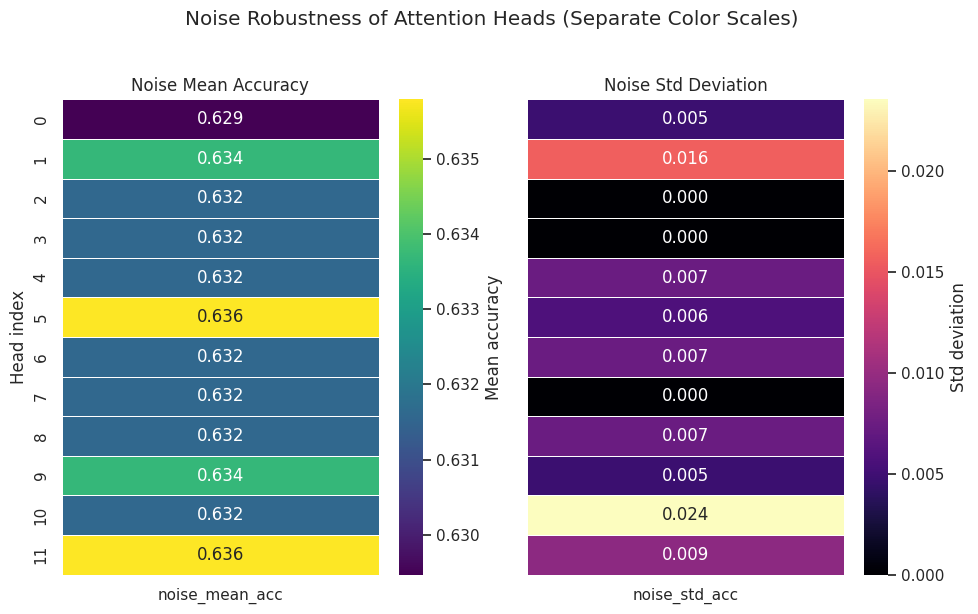

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# df already loaded from CSV
# df columns: head, noise_mean_acc, noise_std_acc

# Set style
sns.set(style="white", font_scale=1.0)

fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 6),
    sharey=True,
    gridspec_kw={"width_ratios": [1, 1]}
)

# ---- LEFT: Noise mean accuracy (sequential colormap) ----
sns.heatmap(
    df[["noise_mean_acc"]],
    ax=axes[0],
    cmap="viridis",
    annot=True,
    fmt=".3f",
    linewidths=0.5,
    cbar=True,
    cbar_kws={"label": "Mean accuracy"}
)

axes[0].set_title("Noise Mean Accuracy")
axes[0].set_xlabel("")
axes[0].set_ylabel("Head index")

# ---- RIGHT: Noise std deviation (different color scale) ----
sns.heatmap(
    df[["noise_std_acc"]],
    ax=axes[1],
    cmap="magma",              # different color scale
    annot=True,
    fmt=".3f",
    linewidths=0.5,
    cbar=True,
    cbar_kws={"label": "Std deviation"}
)

axes[1].set_title("Noise Std Deviation")
axes[1].set_xlabel("")
axes[1].set_ylabel("")

plt.suptitle("Noise Robustness of Attention Heads (Separate Color Scales)", y=1.02)
plt.tight_layout()
plt.show()
